**1.** Libraries required

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import math
from sklearn.utils.extmath import softmax
import random

**2. (a)** Data generation functions and all the activation functions and their derivaties are defined here.

**Also, all the activation, output and loss functions are plugged-in using function-pointers, so further activation functions can be easily added or plugged-in to the model**

In [0]:
def generate_randomList( len_of_randomList, startRange, endRange):
  len_of_generated_list = 0
  random_list = []
  for i in range(2 * len_of_randomList):
    r=random.randint(startRange,endRange)
    if r not in random_list: 
      random_list.append(r)
      len_of_generated_list = len_of_generated_list + 1
    if len_of_generated_list >= len_of_randomList:
      break
  return random_list
"""
generates gaussian or concentric circles with the given number of examples
distributionShape=g for gaussian and c for concentric circles
numOutputs can be 1 or equal to the numClasses

For numOutputs more than 1, OneHotEncoding is used to convert into desired vector

returns X_coord,Y_coord,labels -> labels can be single or multiple depending on the numOutputs
"""
def generateData( numExamples, distributionShape="g", numClasses=2, numOutputs=1 , noise=None):
  totalNumRequired = numExamples
  numExamples = math.ceil(numExamples / numClasses)
  all_classes = []
  # print(numExamples)
  if distributionShape == "g":
    class_iter = 1
    while class_iter <= numClasses:
      origin = 5 * ( 1 if class_iter % 2 == 0 else -1) * ( math.ceil(class_iter/2) ) + ( 0 if class_iter/2 <= 1 else ((2.5 * math.ceil(class_iter/2)) * 1 if class_iter % 2 == 0 else -1 ))
      # print(origin)
      samples = np.random.multivariate_normal([origin, origin], [[1, 1],[1, 1.5]], numExamples)
      labels = np.array([ class_iter - 1])
      all_classes.append(class_iter - 1)
      labels = np.repeat(labels, samples.shape[0])
      if class_iter == 1:
        merged_labels = labels
        merged_samples = samples
      else:
        merged_samples = np.concatenate( (merged_samples , samples) )
        merged_labels = np.concatenate( (merged_labels, labels))
      class_iter = class_iter + 1
    # samples_y = np.random.multivariate_normal([3.5, 3.5], [[1, 1],[1, 2]], numExamples)

  elif distributionShape == "c":
    theta = np.linspace(0, 2*np.pi, numExamples)
    for class_iter in range(numClasses):
      r = np.random.uniform(low=0.75 * class_iter,high= 0.5 + ( 0.75 * class_iter),size=numExamples)
      x, y = r * np.cos(theta), r * np.sin(theta)
      circle_dataFrame = pd.DataFrame(x)
      circle_dataFrame['y'] = y
      samples = np.array(circle_dataFrame)
      labels = np.array([ class_iter ])
      all_classes.append(class_iter)
      labels = np.repeat(labels, samples.shape[0])
      if class_iter == 0:
        merged_labels = labels
        merged_samples = samples
      else:
        merged_samples = np.concatenate( (merged_samples , samples) )
        merged_labels = np.concatenate( (merged_labels, labels))
  if noise is not None:
    numOfNoise = int(math.ceil(totalNumRequired * noise))
    noise_random_list = generate_randomList(numOfNoise,0,totalNumRequired-1)
    for list_iter in noise_random_list:
      dummy_list = all_classes.copy()
      dummy_list.remove(merged_labels[list_iter])
      merged_labels[list_iter] = random.choice(dummy_list)
  test_dataFrame=pd.DataFrame(merged_samples)
  test_dataFrame['label'] = merged_labels
  for each_class in all_classes:
    x = test_dataFrame[test_dataFrame.label == each_class].iloc[:,0]
    y = test_dataFrame[test_dataFrame.label == each_class].iloc[:,1]
    plt.scatter(x, y, color="blue" if each_class % 3 == 0 else "red" if each_class % 2 == 1 else "green")
  if numOutputs > 1 and numOutputs == numClasses:
    del test_dataFrame['label']
    onehot_encoder = OneHotEncoder(sparse=False)
    merged_labels = onehot_encoder.fit_transform(merged_labels.reshape(-1,1))
    for class_iter in range(numOutputs):
      test_dataFrame['label_'+str(class_iter)] = merged_labels[:,class_iter]
  else:
    test_dataFrame['label'] = merged_labels
 
  return np.array(test_dataFrame)

def reLUFn(input_ele):
  return np.maximum(0, input_ele)

def derReLUFn(input_ele):
  return 1. * (input_ele > 0)

def sigmoidFn(input_ele):
  # another method that I found in stackoverflow -> https://stackoverflow.com/questions/3985619/how-to-calculate-a-logistic-sigmoid-function-in-python?noredirect=1
  # to overcome the overflow problem
  return np.exp(-np.logaddexp(0, -input_ele))
  # return 1/(1+ np.exp(-(input_ele)))


def derSigmoidFn(element):
  return sigmoidFn(element) * ( 1 - sigmoidFn(element))

def linearFn(input_ele):
  return input_ele

def derlinearFn(input_ele):
  return 1

def meanSqFn(prediction, target):
  return (1/2) * np.square( prediction - target )

def derMeanSqFn(prediction, target):
  return (prediction - target)

def softMaxFn(input_ele):
  e_x = np.exp(input_ele - np.max(input_ele)) # same code
  return e_x / e_x.sum(axis=-1, keepdims=True)

def derSoftMaxFn(input_ele):
  return 1
  # return input_ele * ( 1 - input_ele)

def crossEntropyFn( prediction, target):
  delta = 1e-7
  return -np.sum(np.multiply(target, np.log(prediction + delta)), axis=1)

def derCrossEntropyFn(prediction, target):
  return (prediction - target)

activationFn = {"S" : sigmoidFn , "R" : reLUFn , "L" : linearFn}
derActivationFn = {"S" : derSigmoidFn , "R" : derReLUFn , "L" : derlinearFn}
outputFn = { "1" : sigmoidFn , "2" : softmax}
deroutputFn = { "1" : derSigmoidFn , "2" : derSoftMaxFn}
# lossFn = { "1" : meanSqFn , "2" : crossEntropyFn }
# derlossFn = { "1" : derMeanSqFn , "2" : derCrossEntropyFn}
lossFn = { "1" : crossEntropyFn , "2" : crossEntropyFn }
derlossFn = { "1" : derCrossEntropyFn , "2" : derCrossEntropyFn}

**3. (b)** Data generation with noise

array([[ 1.99066845e-02,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.88407060e-01,  7.13471156e-03,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 5.13788284e-02,  3.89687684e-03,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.89192086e+00, -1.43494564e-01,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 1.72913923e+00, -6.54800819e-02,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 1.53425719e+00, -3.75784632e-16,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00]])

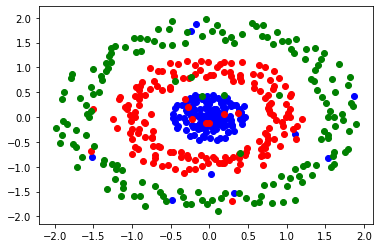

In [30]:
generateData(500, distributionShape='c', numClasses=3 , numOutputs=3, noise=0.05 )

**4. (c,d)** Working:

Feed-forward step:

\begin{equation} outputFirstLayer =  \sum_{} wx + b \end{equation}

\begin{equation} outputPreviousLayer = outputFirstLayer \end{equation}

Runs in loop for the number of hidden layers

\begin{equation} hiddenLayerInput =  outputPreviousLayer \end{equation}

\begin{equation} hiddenLayerOutput =  activationFunction( hiddenLayerInput) \end{equation}

\begin{equation} outputPreviousLayer =  hiddenLayerOutput \end{equation}

Loop ends

\begin{equation} prediction =  outputFunction(hiddenLayerOutput) \end{equation}

Back-propogation:

\begin{equation} ydelta =  - ( d (lossFunction)/dy) * d (outputFunction)/dz \end{equation}

\begin{equation} frontLayer = ydelta \end{equation}

Runs in loop for number of hidden layers:

\begin{equation} hdelta =  (ydelta * weight) * d (activationFunction) / dz \end{equation}

\begin{equation} weight of that layer = weight of that layer - learningRate * (frontLayer * output of that hidden layer) \end{equation}

\begin{equation} frontLayer = hdelta \end{equation}

Loop ends

\begin{equation} weightInitialLayer = weightInitialLayer - learningRate * (input * frontLayer) \end{equation}

By this way, weight of all the layers are optimized using gradient-descent.

The code and explanations are referenced from a blog by Andrew Trask https://iamtrask.github.io/2015/07/12/basic-python-network/

In [0]:
class Model:
  def __init__(self, numInputs=2, numOutputs=1, layerSize=1, numHiddenLayers=2, activationType='R'):
    self.numInputs = numInputs
    self.numOutputs = numOutputs
    self.layerSize = layerSize
    self.numHiddenLayers = numHiddenLayers
    self.activationType = activationType
    self.lossFnType = "1" if numOutputs == 1 else "2"
    self.weights = []
  
  def setInput(self, X):
    self.X = X

  def setTest(self, X_test):
    self.X_test = X_test
  
  """
  initializes weights of the model with the provided mean and std_dev for the dimensions already initialized

  constant_value is provided to initialize all the weights in the model to this value -> for debugging
  """
  def initWeights(self, mean, std_Dev , constant_value=0):
    self.weights = []
    inputWeight = (std_Dev * np.random.random((self.numInputs + 1 , self.layerSize)) + mean) if constant_value == 0 else np.full((self.numInputs + 1 , self.layerSize),constant_value)
    self.weights.append(inputWeight)
    for iter in range(self.numHiddenLayers):
      outSize = self.numOutputs if iter == self.numHiddenLayers - 1 else self.layerSize
      weight = ( std_Dev * np.random.random((self.layerSize , outSize)) + mean ) if constant_value == 0 else np.full((self.layerSize , outSize),constant_value)
      self.weights.append(weight)
    # print(self.weights)

  def setWeights(self, value):
    self.initWeights(0,0,constant_value=value)
  
  """
  gets the test_data and initially adds the bias if not added and using the weights of the model,
  returns the predicted values as arrays

  applies activation functions on the test_data for the number of hidden layers and then applies the
  output function accordingly for the returned value
  """
  def predict(self, test_data):
      if test_data.shape[1] <= self.numInputs:
        # adding bias
        test_data = np.insert(test_data, self.numInputs, 1, axis=1)
      prev_layer = test_data
      layer_iter = 0
      while layer_iter < self.numHiddenLayers:
        z1 = np.dot(prev_layer,self.weights[layer_iter])
        # Activation function
        h = activationFn[self.activationType](z1)
        prev_layer = h
        layer_iter = layer_iter + 1
      ##
      z2 = np.dot(prev_layer ,self.weights[layer_iter])
      prediction = outputFn[self.lossFnType](z2)
      #
      return prediction

  def train(self, numIter=1000 , stepSize=0.1):
    inputElement = self.X[:,0:self.numInputs]
    inputElement = np.insert(inputElement, self.numInputs, 1, axis=1)
    # print(inputElement)
    target = self.X[:,self.numInputs:]
    # print(target)
    # print(self.weights)
    ##
    hidden_layers = []
    error_List = []
    for iter in range(numIter):
      layer_iter = 0
      prev_layer = inputElement
      ## feedforward     
      while layer_iter < self.numHiddenLayers:
        # print(layer_iter)
        h = activationFn[self.activationType](np.dot(prev_layer,self.weights[layer_iter]))
        prev_layer = h
        hidden_layers.append(h)
        layer_iter = layer_iter + 1
        ## 
      y = outputFn[self.lossFnType](np.dot( prev_layer , self.weights[layer_iter]))
      ## back propogation
      y_delta = (-derlossFn[self.lossFnType](y, target)) * deroutputFn[self.lossFnType](y)
      front_layer = y_delta
      while layer_iter > 0:
        weight = self.weights[layer_iter]
        h_delta = np.dot(front_layer, weight.T) * derActivationFn[self.activationType](hidden_layers[layer_iter - 1])
        weight += (stepSize * np.dot(hidden_layers[layer_iter - 1].T, front_layer))
        front_layer = h_delta
        self.weights[layer_iter] = weight 
        layer_iter = layer_iter - 1
        ##
      weight = self.weights[layer_iter]
      weight += (stepSize * np.dot(inputElement.T, front_layer))
      self.weights[layer_iter] = weight
      each_iter_list = []
      each_iter_prediction = self.predict(inputElement)
      each_iter_loss = lossFn[self.lossFnType](each_iter_prediction,target)
      each_iter_list.append(np.average(each_iter_loss))
      each_iter_list.append(np.average(self.test()))
      error_List.append(each_iter_list)
    return np.array(error_List)

  def test(self):
    inputElement = self.X_test[:,0:self.numInputs]
    inputElement = np.insert(inputElement, self.numInputs, 1, axis=1)
    target = self.X_test[:,self.numInputs:]
    prediction = self.predict(inputElement)
    loss = lossFn[self.lossFnType](prediction,target)
    return loss

**5. (e,f,h)** 2 class, 1 input gaussian distribution data was used to train the model with 'S' activation function.



---

**Hyper parameters**

*   8 neurons
*   Learning rate - 0.1
*   Number of hidden layers - 2

**Inference**

* Average Train error on the model - 0.01795745
* Average Test error on the model - 0.018759121105274782
* Prediction is done for another random data samples and the average error was - 0.0180376164473796
* L - performs the best in gaussian since a linear line can split the datasets



Train Result:
[[0.63116087 0.65888036]
 [0.00617351 0.00646272]
 [2.22862902 2.32197377]
 ...
 [0.01798669 0.01878967]
 [0.01797206 0.01877438]
 [0.01795745 0.01875912]]
Test Error
0.018759121105274782
Prediction Error
0.0180376164473796
Prediction
[[0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980878]
 [0.02980

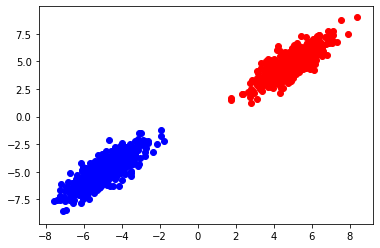

In [34]:
# X = generateData(500)
numOutputsUsed=1
numOfClasses=2
X = generateData(500,distributionShape="g",numOutputs=numOutputsUsed,numClasses=numOfClasses)
np.random.shuffle(X)
X_train = X[:450]
X_test = X[450:]
net = Model(layerSize=8,numHiddenLayers=2,activationType="S",numOutputs=numOutputsUsed)
net.setInput(X_train)
net.setTest(X_test)
net.initWeights(0.0,0.1)
trainError = net.train(1000,0.1)
print("Train Result:")
print(trainError)
testError = net.test()
print("Test Error")
print(np.average(testError))
Y = generateData(500,distributionShape="g",numOutputs=numOutputsUsed,numClasses=numOfClasses)
prediction = net.predict(Y[:,:2])
target = Y[:,2:]
loss = lossFn["1" if numOutputsUsed == 1 else "2"](prediction,target)
print("Prediction Error")
print(np.average(loss))
print("Prediction")
print(prediction)

**6. (g)** 3 class concentric circle data was used to train the model with 'R' activation function.



---

**Hyper parameters**

*   100 neurons
*   Learning rate - 0.1
*   Number of hidden layers - 1

**Inference**

* Average Train error on the model - 0.09651544341891706
* Prediction is done for another random data samples and the average error was - 0.2573746824504373
* For concentric circles dataset, R performs the best for both single output and multiple output but only more hidden units in the hidden layers else the circle cannot be split linearly by the model and results in poor performance



Train Result:
[[ 1.87251378e+00  2.30820856e+00]
 [ 1.09861199e+00  1.09861199e+00]
 [ 5.34277940e+00  2.78106518e+00]
 ...
 [ 4.65633777e-01 -9.99999951e-08]
 [ 4.29815787e-01  6.32082086e-01]
 [ 5.37269758e-01 -9.99999951e-08]]
Test Error
-9.999999505838702e-08
Prediction Error
0.4504057692882614
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


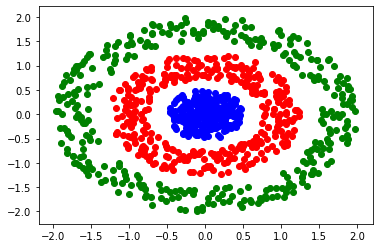

In [32]:
# X = generateData(500)
numOutputsUsed=3
numOfClasses=3
X = generateData(500,distributionShape="c",numOutputs=numOutputsUsed,numClasses=numOfClasses)
net = Model(layerSize=100,numHiddenLayers=1,activationType="R",numOutputs=numOutputsUsed)
np.random.shuffle(X)
X_train = X[:450]
X_test = X[450:]
net.setInput(X_train)
net.initWeights(0.0,0.1)
net.setTest(X_test)
trainError = net.train(1000,0.1)
print("Train Result:")
print(trainError)
testError = net.test()
print("Test Error")
print(np.average(testError))
Y = generateData(500,distributionShape="c",numOutputs=numOutputsUsed,numClasses=numOfClasses)
prediction = net.predict(Y[:,:2])
target = Y[:,2:]
loss = lossFn["1" if numOutputsUsed == 1 else "2"](prediction,target)
print("Prediction Error")
print(np.average(loss))
print(prediction)

**Inferences:**

* The accuracy and performance of the model is dependent mostly on the floating point calculations and its accuracy. 
* [Diff Checker](https://www.diffchecker.com/Jio4EAOM) - link to my saved diff checker, where a mere 0.0001 difference in the floating point calculation resulted in the model to perform half its best. This problem in deep learning is known as **loss of significance** or Catastrophic cancellation - link to a [IEEE paper](https://www.researchgate.net/publication/220261458_A_Remarkable_Example_of_Catastrophic_Cancellation_Unraveled). I have tried fine-tuning the hyper-parameters, i.e increased the iteration count to arrive correct weights, in order to solve this issue.